In [1]:
import pandas as  pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
def get_precision_dataframe(dataframe, columns):
    agrupado = dataframe.groupby(columns).agg(total=("ID_USER", "count"),  fraudes=("target", "sum")
                                             )
    agrupado["propor"] = agrupado["fraudes"]/agrupado["total"]

    return agrupado.sort_values(by=["propor"], ascending=False)

In [4]:
def interval_month(day):
    if ((day >= 27) | (day <=3)):
        return "end_month"
    if ((day >= 12) & (day <=18)):
        return "middle_month"
    if (day < 12):
        return "firsthalf_month"
    if (day > 18):
        return "lasthalf_month"
    return "default"

def week_day(day):
    if day >= 4:
        return "end_week"
    
    return "work_week"
def get_time(day):
    if day<=6:
        return "madrugada"
    
    if day<=12:
        return "manana"
    
    if day<=19:
        return "tarde"
    return "noche"

In [5]:
# Lunes => 0 Domingo => 6

In [6]:
def prepare_data(dataframe):
    numeric_fields = ["ID_USER", "monto", "hora", "linea_tc", "interes_tc", "dcto", "cashback"]
    for fld in numeric_fields:
        dataframe[fld] = pd.to_numeric(dataframe[fld]) 
    dataframe["fecha"] = pd.to_datetime(dataframe["fecha"]).dt.date
    
    dataframe["weekday"] = pd.to_datetime(dataframe["fecha"]).dt.weekday.apply(week_day)
    dataframe["monthday"] = pd.to_datetime(dataframe["fecha"]).dt.day.apply(interval_month)
    dataframe["momentday"] = dataframe["hora"].apply(get_time)
    
    # Filling genero field
    genero_moda = dataframe["genero"].mode()[0]
    dataframe["genero"] = dataframe["genero"].apply(lambda gn:  None if ((gn is None) | (gn not in ["M", "F"])) else gn)
    dataframe["genero_1"] = dataframe["genero"].fillna(genero_moda).apply(lambda el: 1 if el == "M" else 0)
    
    dataframe["mobile"] = dataframe["dispositivo"].apply(lambda dc: json.loads(dc.replace("'",'"')))
    dataframe["device_score"] = dataframe["mobile"].apply(lambda el:  el["device_score"])
    dataframe["os"] = dataframe["mobile"].apply(lambda el:  el["os"])
    
    # Adding target field
    dataframe["target"] = dataframe["fraude"].apply(lambda el: 1 if el == True else 0)
    
    # Imputting stage
    dataframe["establecimiento"] = dataframe["establecimiento"].fillna("no-definido")
    dataframe["ciudad"] = dataframe["ciudad"].fillna("no-definido")
    
    return dataframe

In [7]:
dataframe = pd.read_csv("ds_challenge_apr2021.csv")
dataframe =  prepare_data(dataframe)

In [8]:
dataframe.head(3)

ID_USER genero       monto       fecha  hora  \
0        0      F  608.345634  2020-01-21    20   
1        0      F   88.719243  2020-01-15     7   
2        1      F  790.037653  2020-01-17    11   

                                           dispositivo establecimiento  \
0  {'model': 2020, 'device_score': 3, 'os': 'ANDROID'}           Super   
1  {'model': 2020, 'device_score': 1, 'os': 'ANDROID'}     no-definido   
2        {'model': 2020, 'device_score': 1, 'os': '.'}     no-definido   

        ciudad  tipo_tc  linea_tc  interes_tc  status_txn  is_prime  \
0       Merida   Física     71000          51    Aceptada     False   
1       Merida  Virtual     71000          51    Aceptada     False   
2  Guadalajara  Virtual     94000          56  En proceso     False   

        dcto   cashback  fraude    weekday        monthday momentday  \
0  60.834563   5.475111   False  work_week  lasthalf_month     noche   
1   0.000000   1.774385   False  work_week    middle_month    manana   
2   0.000000  15.800753   False   end_week    middle_month    manana   

   genero_1                                               mobile  \
0         0  {'model': 2020, 'device_score': 3, 'os': 'ANDROID'}   
1         0  {'model': 2020, 'device_score': 1, 'os': 'ANDROID'}   
2         0        {'model': 2020, 'device_score': 1, 'os': '.'}   

   device_score       os  target  
0             3  ANDROID       0  
1             1  ANDROID       0  
2             1        .       0

# Exploratorio

In [9]:
#aggregation_dataframe = dataframe.groupby("target").agg(total=("ID_USER", "count"))
rows_count = dataframe.shape[0]
ones_count = dataframe.query("target == 1").shape[0]
zeros_count = rows_count - ones_count
global_precision = ones_count/rows_count

La muestra comprende un total de: 26,975 registros.


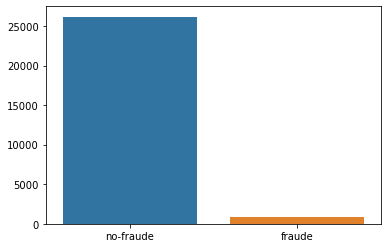

El porcentaje de 1s (810) en la muestra representa el 3.00 % del total de la población. 
Es un problema desvalanceado


In [10]:
print("La muestra comprende un total de: \033[1m{:,}\033[0m registros.".format(rows_count))
sns.barplot(x=["no-fraude", "fraude"], y=[zeros_count, ones_count])
plt.show()
print("El porcentaje de 1s (\033[1m{}\033[0m) en la muestra representa el \033[1m{:.2f}\033[0m % del total de la población. \nEs un problema desvalanceado".format(ones_count, global_precision*100))

# Precisión variables

In [11]:
numeric_fields = ["monto", "dcto", "linea_tc", "interes_tc", "cashback"]
categorical_vars = ["device_score", "establecimiento", "os", "ciudad", "genero", "tipo_tc", "is_prime", "weekday", "monthday", "momentday"]

In [12]:

from sklearn.preprocessing import KBinsDiscretizer


enc = KBinsDiscretizer(n_bins=10, encode="ordinal")
X_binned = enc.fit_transform(dataframe[numeric_fields])


/home/juan/anaconda3/envs/rappi/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [13]:
new_df = pd.DataFrame(X_binned, columns=numeric_fields)
new_df["ID_USER"] = dataframe["ID_USER"]
new_df["target"] = dataframe["target"]

In [14]:

for cat in numeric_fields:
    display(HTML("<h3>"+cat+"</h3>"))
    display(get_precision_dataframe(new_df, [cat]).sort_values(cat))

total  fraudes    propor
monto                          
0.0     2698       84  0.031134
1.0     2696       81  0.030045
2.0     2699       80  0.029641
3.0     2697       93  0.034483
4.0     2697       85  0.031516
5.0     2698       69  0.025574
6.0     2697       86  0.031887
7.0     2697       73  0.027067
8.0     2697       80  0.029663
9.0     2699       79  0.029270

total  fraudes    propor
dcto                          
0.0   18882      574  0.030399
1.0    2698       78  0.028910
2.0    2697       81  0.030033
3.0    2698       77  0.028540

total  fraudes    propor
linea_tc                          
0.0        2579       80  0.031020
1.0        2709       74  0.027316
2.0        2614       78  0.029839
3.0        2472       87  0.035194
4.0        2726       86  0.031548
5.0        2726       76  0.027880
6.0        2855       79  0.027671
7.0        2887       79  0.027364
8.0        2419       85  0.035138
9.0        2988       86  0.028782

total  fraudes    propor
interes_tc                          
0.0          2545       78  0.030648
1.0          2289       69  0.030144
2.0          3057      102  0.033366
3.0          2405       72  0.029938
4.0          2351       73  0.031051
5.0          3508       97  0.027651
6.0          2360       61  0.025847
7.0          2309       65  0.028151
8.0          2731       90  0.032955
9.0          3420      103  0.030117

total  fraudes    propor
cashback                          
0.0        2698       89  0.032987
1.0        2697       76  0.028179
2.0        2698       86  0.031875
3.0        2697       92  0.034112
4.0        2697       77  0.028550
5.0        2697       81  0.030033
6.0        2698       76  0.028169
7.0        2698       85  0.031505
8.0        2697       64  0.023730
9.0        2698       84  0.031134

In [15]:

for cat in categorical_vars:
    display(HTML("<h3>"+cat+"</h3>"))
    display(get_precision_dataframe(dataframe, [cat]))

total  fraudes    propor
device_score                          
4              5435      183  0.033671
3              5286      164  0.031025
1              5404      157  0.029053
2              5419      155  0.028603
5              5431      151  0.027803

total  fraudes    propor
establecimiento                          
no-definido      10119      317  0.031327
MPago             3343      104  0.031110
Super             3402      102  0.029982
Abarrotes         3415      102  0.029868
Farmacia          3242       92  0.028378
Restaurante       3454       93  0.026925

total  fraudes    propor
os                               
ANDROID   6686      216  0.032306
%%        6808      213  0.031287
.         6715      192  0.028593
WEB       6766      189  0.027934

total  fraudes    propor
ciudad                               
Merida        3761      120  0.031906
Guadalajara   3833      118  0.030785
no-definido  11678      354  0.030313
Toluca        3997      118  0.029522
Monterrey     3706      100  0.026983

total  fraudes    propor
genero                          
F       10726      334  0.031139
M       13519      388  0.028700

total  fraudes    propor
tipo_tc                          
Física   18903      579  0.030630
Virtual   8072      231  0.028617

total  fraudes    propor
is_prime                          
False     23416      710  0.030321
True       3559      100  0.028098

total  fraudes    propor
weekday                            
work_week  15790      492  0.031159
end_week   11185      318  0.028431

total  fraudes    propor
monthday                                 
middle_month      6533      209  0.031991
lasthalf_month    7439      227  0.030515
end_month         5625      170  0.030222
firsthalf_month   7378      204  0.027650

total  fraudes    propor
momentday                          
noche       4657      152  0.032639
tarde       8237      259  0.031443
manana      6983      217  0.031075
madrugada   7098      182  0.025641